<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Logistics" data-toc-modified-id="Logistics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Logistics</a></span></li><li><span><a href="#Introduction-to-DYNAP-SE" data-toc-modified-id="Introduction-to-DYNAP-SE-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Introduction to DYNAP-SE</a></span><ul class="toc-item"><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Import libraries</a></span></li></ul></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pipeline</a></span><ul class="toc-item"><li><span><a href="#Connecting-with-the-board" data-toc-modified-id="Connecting-with-the-board-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Connecting with the board</a></span></li><li><span><a href="#Create-Neuron-and-Neuron-Group" data-toc-modified-id="Create-Neuron-and-Neuron-Group-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Create Neuron and Neuron Group</a></span></li><li><span><a href="#Create-Connection" data-toc-modified-id="Create-Connection-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Create Connection</a></span></li><li><span><a href="#[IMPORTANT]-Set-configuration-on-chip" data-toc-modified-id="[IMPORTANT]-Set-configuration-on-chip-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>[IMPORTANT] Set configuration on chip</a></span></li><li><span><a href="#Input-Stimuli" data-toc-modified-id="Input-Stimuli-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Input Stimuli</a></span><ul class="toc-item"><li><span><a href="#Spike-Generator" data-toc-modified-id="Spike-Generator-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>Spike Generator</a></span></li><li><span><a href="#Poisson-Generator" data-toc-modified-id="Poisson-Generator-3.5.2"><span class="toc-item-num">3.5.2&nbsp;&nbsp;</span>Poisson Generator</a></span></li></ul></li><li><span><a href="#Moniton-Neurons" data-toc-modified-id="Moniton-Neurons-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Moniton Neurons</a></span></li><li><span><a href="#Setting-the-Biases" data-toc-modified-id="Setting-the-Biases-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Setting the Biases</a></span></li></ul></li><li><span><a href="#Creating-a-network-in-a-&quot;DYNAP-SE1-chip&quot;" data-toc-modified-id="Creating-a-network-in-a-&quot;DYNAP-SE1-chip&quot;-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Creating a network in a "DYNAP-SE1 chip"</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Simulation-with-Poisson-input" data-toc-modified-id="Simulation-with-Poisson-input-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Simulation with Poisson input</a></span></li></ul></li></ul></li><li><span><a href="#NMDA-Synapse" data-toc-modified-id="NMDA-Synapse-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>NMDA Synapse</a></span></li><li><span><a href="#Test-GABA_A-and--GABA_B" data-toc-modified-id="Test-GABA_A-and--GABA_B-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Test GABA_A and  GABA_B</a></span></li></ul></div>

# 1. Connecting to Zemo through LAN

For this lab, there is no need to connect to INI VPN since we will be using a LAN cable directly


**Step 1:** From your **local machine** terminal, SSH to Zemo using the username and password sent to you by email:
10.65.48.134 is the Zemo's IP address.

`ssh -X username@10.65.48.134`


**Step 2a:** **On Zemo**, install the correct version of samna:

`pip install samna==0.18.0.0`

also install pandas: `pip install pandas`

**Step 2b:** **On Zemo**, install jupyter 
*If you are using VSCode, you can setup remote developement via the [Remote-SSH extension](https://code.visualstudio.com/docs/remote/ssh) and work with Jupyter notebooks in VSCode.*

**Step 3** **On Zemo**, launch the notebook 

`jupyter notebook --no-browser --port=8866`


**Step 4**: **Back to your loval machine**

`ssh -N -f -L 8866:localhost:8866 username@10.65.48.134`


**Additional useful commands:**

- Map remote directory to local folder: 

`sshfs username@10.65.48.134:/home/username/dir_name local_directory`

- To copy (same PC): `cp -R <source_folder> <destination_folder>`

- To copy (from remote to local):

`scp username@10.65.48.134:/remote_dir_path/Hello_world.ipynb /local_dir_path/folder_name`

- To copy (from local to remote):

`scp local_dir_path/Hello_world.ipynb  username@10.65.134:/remote_dir_path/`

## Import libraries

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import time
import pandas as pd

# Display plots inside Jupyter cell
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90

sys.path.append('/home/class_NI2021/ctxctl_contrib_2023')

**`Python` wrapper classes implements the DPI neuron, synaptic circuit models and monitors chip resources (e.g., number of available neurons per core, number of synapses between neurons, etc.)**

In [2]:
import samna
import samna.dynapse1 as dyn1
from dynapse1constants import *
import dynapse1utils as ut
import netgen as n
import params
from bias_names import BIAS_NAMES

In [3]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# Pipeline

## Connecting with the board

A list of the currently available boards to use:

|Board Serial Number|Port to connect to|
| :-- | :-- | 
Device 3 Dynapse1DevKit serial_number 00000001 | sender_port=16344, receiver_port=17245 |
Device 13 Dynapse1DevKit serial_number 00000011 | sender_port=17349, receiver_port=15347 |
Device 12 Dynapse1DevKit serial_number 00000027 | sender_port=12344, receiver_port=12345 |
Device 6 Dynapse1DevKit serial_number 00000020 | sender_port=13923, receiver_port=11992 |
Device 4 Dynapse1DevKit serial_number 00000000 | sender_port=16725, receiver_port=11204 |

Upon calling `open_dynapse1`, you will prompted to select the device by index. Note that the index of a given board can change each time you re-run, so double check on the board serial_number and use its corresponding index.

In [4]:
# open DYNAP-SE1 board to get Dynapse1Model. Use the index specified on the leftmostside to select a device
device_name = 'dynpase_test' # pick any name
model,no_gui = ut.open_dynapse1(gui=False, sender_port=1620, receiver_port=12377, select_device=True) # returns Dynapse1Model

[0]:  Bus 1 Device 27 Dynapse1DevKit serial_number 00000000
[1]:  Bus 1 Device 24 Dynapse1DevKit serial_number 00000020
[2]:  Bus 1 Device 26 Dynapse1DevKit serial_number 00000011
Sender port: tcp://0.0.0.0:1620
Receiver port: tcp://0.0.0.0:12377
Opened device name: Dynapse1DevKit
SamnaNode ID: 1
PythonNode ID: 2


In [5]:
# silent all neurons
paramGroup = params.gen_clean_param_group()
for chip in range(4):
    for core in range(4):
        model.update_parameter_group(paramGroup, chip, core)

## Setting the Biases



DPI neuronal parameters
***
| Bias Name | Description |
| :-- | :-- | 
| IF_THR_N | the gain factor of neuron. |
| IF_TAU1_N/IF_TAU2_N | the membrane time-constant of leakage current. |
| IF_RFR_N | refractory period. |
| IF_DC_P | Inject constant current. |

***
Synaptic parameters
***

| Abbreviations | Description |
| :-- | :-- |
|F_P | Fast |
|S_P | Slow |
|II | Inhibitory |
|EE | Excitatory |
    
***
Bias names: `NPDPIE_TAU_F_P,NPDPIE_TAU_S_P,NPDPII_TAU_F_P,NPDPII_TAU_S_P`
    

NPDP[II_or_IE]\_TAU\_[F_or_S]_P : corresponds to **leakage current**, i.e. how much current is constantly leaked away. It represents the time-constant of current decay. 
    
*** 
    
Bias names: `NPDPIE_THR_F_P, NPDPIE_THR_S_P, NPDPII_THR_F_P, NPDPII_THR_S_P`
    

NPDP[II_or_IE]\_THR\_[F_or_S]_P: the gain factor of the synapse. 

*** 
    
Bias names: `PS_WEIGHT_EXC_F_N,PS_WEIGHT_EXC_S_N,PS_WEIGHT_INH_F_N,PS_WEIGHT_INH_S_N` : Weight Bias
*** 
    
Bias name: `IF_NMDA_N`: Sets NMDA gating-threshold

***



There are biases to set adaptation but that is not listed here.

The biases are tuned via two knobs:

    - a coarse value: [0,8)
    - a fine value: [0, 256)
    


<div class="alert alert-block alert-danger">
    
Remark: For projects, json and txt file for parameter would be better, I will send the example files later via email 
</div>

## NMDA Synapse

TypeError: 'NeuronGroup' object is not subscriptable

In [75]:
# Create a population of neurons to receive 
net_gen = n.NetworkGenerator()

# Spike Generator for NMDA input + for AMPA input
spike_gens = [10,11]
spgen_chip_id = 0
spgen_core_id = 1

# nids = np.arange(100, 100 + n_mu, 1)

spikegen_nmda = n.NeuronGroup(spgen_chip_id , spgen_core_id, [spike_gens[0]] ,True) 
spikegen_ampa = n.NeuronGroup(spgen_chip_id , spgen_core_id, [spike_gens[1]] ,True) 

# print(f'Spike Gen\n Chip Id: {spikegen.chip_id}, Core Id: {spikegen.core_id},  Ids: {spikegen.neuron_ids},  Object: {spikegen.neurons}')


# Output DPI neuron population representing a singlf DoF
neu_chip_id = 0
neu_core_id = 1
neu_pop = 5

neu_ids = np.arange(14, 14 + neu_pop ,1)
DPI_neuron = n.NeuronGroup(neu_chip_id, neu_core_id, neu_ids)

# Connect all2all with AMPA synpase
syn = n.Synapses(spikegen_nmda, DPI_neuron, dyn1.Dynapse1SynType.NMDA, conn_type='all2all')

n.add_synapses(net_gen, syn)

syn = n.Synapses(spikegen_ampa, DPI_neuron, dyn1.Dynapse1SynType.AMPA, conn_type='all2all')

n.add_synapses(net_gen, syn)

print(net_gen.network)

Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C0c1n17: [('C0c1s10', 'NMDA'), ('C0c1s11', 'AMPA')]
C0c1n14: [('C0c1s10', 'NMDA'), ('C0c1s11', 'AMPA')]
C0c1n18: [('C0c1s10', 'NMDA'), ('C0c1s11', 'AMPA')]
C0c1n16: [('C0c1s10', 'NMDA'), ('C0c1s11', 'AMPA')]
C0c1n15: [('C0c1s10', 'NMDA'), ('C0c1s11', 'AMPA')]



In [76]:
# apply configuration
current_config = net_gen.make_dynapse1_configuration()
model.apply_configuration(current_config)

In [77]:
def organize_results(events, df_spikes=None):
    # evts_n = np.array([[evt.timestamp, evt.neuron_id] for evt in events])
    timestamp_offset = 0 
    if df_spikes is None:
        df_spikes = pd.DataFrame()
    for evt in events:
        if timestamp_offset==0:
            timestamp_offset = evt.timestamp
        spikeData = dict(chip = evt.chip_id, 
                        core = evt.core_id,
                        neuron_id = evt.neuron_id,
                        times =(evt.timestamp-timestamp_offset)* 1e-6)
        df_spikes = pd.concat([df_spikes,pd.DataFrame(spikeData,index=[0])])
    return df_spikes

- Step#1: Connect AMPA and make sure you get firing at 100 Hz
- Step#2: Connect NMDA, but make sure weight of AMPA is set to 0 and the leak is set to coarse 7. The reason is that: slow leak and high gain leads neuron to be



In [174]:
# Set biases for nmda threshold and DC injection
def set_bias_nmda():
    paramGroup = dyn1.Dynapse1ParameterGroup()
    # THR, gain factor of neurons

    # leakage of AMPA: this is fast
    paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 7 #5
    paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value = 125

    # gain of AMPA
    paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 5
    paramGroup.param_map["NPDPIE_THR_F_P"].fine_value = 40

    # weight of AMPA
    paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 0 #6
    paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 0  #30

    #------------------------NMDA-zeft----------------------#
    # first keep NMDA threshold to 0: i.e deactivate (AMPA_like) at coarse 0
    paramGroup.param_map["IF_NMDA_N"].coarse_value = 5 #6 #0
    paramGroup.param_map["IF_NMDA_N"].fine_value = 100#100 #0
    #

    # # Adjust weight of NMDA
    paramGroup.param_map["PS_WEIGHT_EXC_S_N"].coarse_value = 5 #0
    paramGroup.param_map["PS_WEIGHT_EXC_S_N"].fine_value = 60

    # # NMDA time constant
    paramGroup.param_map["NPDPIE_TAU_S_P"].coarse_value = 2
    paramGroup.param_map["NPDPIE_TAU_S_P"].fine_value = 125
    
    # NMDA gain
    paramGroup.param_map["NPDPIE_THR_S_P"].coarse_value = 4
    paramGroup.param_map["NPDPIE_THR_S_P"].fine_value = 80

    #--------------------Neuron--------------------------#
    # Inject current to make neuron fire
    paramGroup.param_map["IF_DC_P"].coarse_value = 0
    paramGroup.param_map["IF_DC_P"].fine_value = 0

    # Reduce neuron leakage
    paramGroup.param_map["IF_TAU1_N"].coarse_value = 4
    paramGroup.param_map["IF_TAU1_N"].fine_value = 80

    return paramGroup


In [175]:
chip_param = set_bias_nmda()
model.update_parameter_group(chip_param, DPI_neuron.chip_id, DPI_neuron.core_id)


In [167]:
temp_config  = model.get_configuration()
display_model_config(temp_config, DPI_neuron.chip_id, DPI_neuron.core_id, param_name='PS_WEIGHT_EXC_S_N')


PS_WEIGHT_EXC_S_N  Coarse:5    Fine:60


In [168]:
# model.update_single_parameter(dyn1.Dynapse1Parameter("IF_NMDA_N", 0,0), DPI_neuron.chip_id, DPI_neuron.core_id)

In [169]:
# set the input
poisson_gen = model.get_poisson_gen()

# get global ids of neurons
spikegen_gids_nmda = ut.get_global_id_list(spikegen_nmda.tuple_neuron_ids)  
spikegen_gids_ampa = ut.get_global_id_list(spikegen_ampa.tuple_neuron_ids)  

print(spikegen_gids_nmda,spikegen_gids_ampa )

# Set target chip
post_chip = DPI_neuron.chip_id
poisson_gen.set_chip_id(post_chip)

rate_nmda = 100#20 #in Hz
rate_ampa = 100

poisson_gen.write_poisson_rate_hz(spikegen_gids_nmda[0], rate_nmda)
poisson_gen.write_poisson_rate_hz(spikegen_gids_ampa[0], rate_ampa)

[266] [267]


In [176]:
# Create a graph to monitor output spikes
graph, filter_node, sink_node = ut.create_neuron_select_graph(model, DPI_neuron.tuple_neuron_ids)

# start gens
poisson_gen.start()

# Start graph 
graph.start()

# Clear buffer
sink_node.get_events()

for i in range(3):
    # get spikes every 2 seconds
    time.sleep(4)
    events = sink_node.get_events()
    # process the events
    print(len(events),"events.")

graph.stop()
poisson_gen.stop()

# Organize events
results_df = organize_results(events)

17 events.
15 events.
15 events.


Text(0.5, 1.0, 'Output spikes')

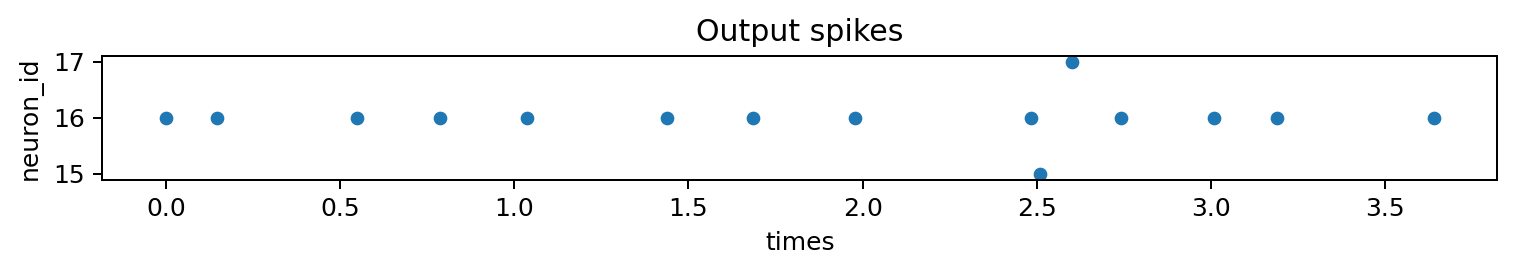

In [177]:
# plot input spikes 
fig = plt.figure(figsize=(10,2))

ax = fig.add_subplot(2,1,1)
results_df.plot(x='times', y='neuron_id',kind='scatter', ax=ax)
plt.title("Output spikes")

# ax = fig.add_subplot(2,1,2)
# ax

## GABA_A and  GABA_B synapses
  

In [ ]:
import samna
import samna.dynapse1 as dyn1
import time

import sys
# # change the path to '/home/class_NI2021/ctxctl_contrib' on zemo
# sys.path.insert(1, '/home/jingyue/aa_projects/ctxctl_contrib')
# from Dynapse1Constants import *
# import Dynapse1Utils as ut
# import NetworkGenerator as n
# from NetworkGenerator import Neuron
# import numpy as np

def gen_param_group_1core():
    paramGroup = dyn1.Dynapse1ParameterGroup()
    # THR, gain factor of neurons
    paramGroup.param_map["IF_THR_N"].coarse_value = 5
    paramGroup.param_map["IF_THR_N"].fine_value = 80

    # refactory period of neurons
    paramGroup.param_map["IF_RFR_N"].coarse_value = 4
    paramGroup.param_map["IF_RFR_N"].fine_value = 128

    # leakage of neurons
    paramGroup.param_map["IF_TAU1_N"].coarse_value = 4
    paramGroup.param_map["IF_TAU1_N"].fine_value = 80

    # turn off tau2
    paramGroup.param_map["IF_TAU2_N"].coarse_value = 7
    paramGroup.param_map["IF_TAU2_N"].fine_value = 255

    # turn off DC
    paramGroup.param_map["IF_DC_P"].coarse_value = 0
    paramGroup.param_map["IF_DC_P"].fine_value = 0

    # leakage of AMPA
    paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 4
    paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value = 80

    # gain of AMPA
    paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 4
    paramGroup.param_map["NPDPIE_THR_F_P"].fine_value = 80

    # weight of AMPA
    paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 0
    paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 0

    # leakage of NMDA
    paramGroup.param_map["NPDPIE_TAU_S_P"].coarse_value = 4
    paramGroup.param_map["NPDPIE_TAU_S_P"].fine_value = 80

    # gain of NMDA
    paramGroup.param_map["NPDPIE_THR_S_P"].coarse_value = 4
    paramGroup.param_map["NPDPIE_THR_S_P"].fine_value = 80

    # weight of NMDA
    paramGroup.param_map["PS_WEIGHT_EXC_S_N"].coarse_value = 0
    paramGroup.param_map["PS_WEIGHT_EXC_S_N"].fine_value = 0

    # leakage of GABA_A (shunting)
    paramGroup.param_map["NPDPII_TAU_F_P"].coarse_value = 4
    paramGroup.param_map["NPDPII_TAU_F_P"].fine_value = 80

    # gain of GABA_A (shunting)
    paramGroup.param_map["NPDPII_THR_F_P"].coarse_value = 4
    paramGroup.param_map["NPDPII_THR_F_P"].fine_value = 80

    # weight of GABA_A (shunting)
    paramGroup.param_map["PS_WEIGHT_INH_F_N"].coarse_value = 0
    paramGroup.param_map["PS_WEIGHT_INH_F_N"].fine_value = 0

    # leakage of GABA_B
    paramGroup.param_map["NPDPII_TAU_S_P"].coarse_value = 4
    paramGroup.param_map["NPDPII_TAU_S_P"].fine_value = 80

    # gain of GABA_B
    paramGroup.param_map["NPDPII_THR_S_P"].coarse_value = 4
    paramGroup.param_map["NPDPII_THR_S_P"].fine_value = 80

    # weight of GABA_B
    paramGroup.param_map["PS_WEIGHT_INH_S_N"].coarse_value = 0
    paramGroup.param_map["PS_WEIGHT_INH_S_N"].fine_value = 0

    # other advanced parameters
    paramGroup.param_map["IF_NMDA_N"].coarse_value = 0
    paramGroup.param_map["IF_NMDA_N"].fine_value = 0

    paramGroup.param_map["IF_AHTAU_N"].coarse_value = 4
    paramGroup.param_map["IF_AHTAU_N"].fine_value = 80

    paramGroup.param_map["IF_AHTHR_N"].coarse_value = 0
    paramGroup.param_map["IF_AHTHR_N"].fine_value = 0

    paramGroup.param_map["IF_AHW_P"].coarse_value = 0
    paramGroup.param_map["IF_AHW_P"].fine_value = 0

    paramGroup.param_map["IF_CASC_N"].coarse_value = 0
    paramGroup.param_map["IF_CASC_N"].fine_value = 0

    paramGroup.param_map["PULSE_PWLK_P"].coarse_value = 4
    paramGroup.param_map["PULSE_PWLK_P"].fine_value = 106

    paramGroup.param_map["R2R_P"].coarse_value = 3
    paramGroup.param_map["R2R_P"].fine_value = 85

    paramGroup.param_map["IF_BUF_P"].coarse_value = 3
    paramGroup.param_map["IF_BUF_P"].fine_value = 80

    return paramGroup

# --------------- GABA_A inhibition ----------------
# first reuse part1 to make the neuron fire at 100Hz
# with proper parameters, then add 1 GABA_A synapse 
# between a Poissongen and this neuron. Use different
# input rate to inhibit the neuron and monitor its output rates.

# open DYNAP-SE1 board to get Dynapse1Model
# device_name = "my_dynapse1"
# # change the port numbers to not have conflicts with other groups
# store = ut.open_dynapse1(device_name, gui=False, sender_port=12345, receiver_port=12346)
# model = getattr(store, device_name)

# # set initial (proper) parameters
# paramGroup = gen_param_group_1core()
# for chip in range(4):
#     for core in range(4):
#         model.update_parameter_group(paramGroup, chip, core)

# select a spike generator
schip = 0
score = 0
sid = 1

# choose a neuron to monitor.
chip = 0
core = 1
nid = 16

# inh weights
w_coarse_value = 7
w_fine_values = np.arange(0, 250, 100)

# input rates
input_freqs = np.arange(20, 200, 20)

duration = 1

# result frequency list
output_rates = np.zeros((len(w_fine_values), len(input_freqs)))

# get the global neuron ID of the neuron
monitored_global_nid = ut.get_global_id(chip, core, nid)

####################### TODO #######################
# tune parameters, you may change the params below
# but feel free to play with more options

# set DC of this core
param = dyn1.Dynapse1Parameter("IF_DC_P", 4, 200)
model.update_single_parameter(param, chip, core)
# decrease the leak
param = dyn1.Dynapse1Parameter("IF_TAU1_N", 3, 40)
model.update_single_parameter(param, chip, core)

# GABA_B, NPDPII_THR_F_P
param = dyn1.Dynapse1Parameter("NPDPII_THR_F_P", 5, 80)
model.update_single_parameter(param, chip, core)
# GABA_B, NPDPII_TAU_F_P
param = dyn1.Dynapse1Parameter("NPDPII_TAU_F_P", 3, 20)
model.update_single_parameter(param, chip, core)
####################### TODO #######################


####################### TODO #######################
# build network
# init a network generator
net_gen = n.NetworkGenerator()
spikegen = n.Neuron(schip, score, sid, True)
neuron = n.Neuron(chip, core, nid)

# connect spikegen to neuron (only in the network topology not chips for now)
net_gen.add_connection(spikegen, neuron, dyn1.Dynapse1SynType.GABA_A)

# print the network so you can double check (optional)
net_gen.print_network()
# make a dynapse1config using the network
new_config = net_gen.make_dynapse1_configuration()
# apply the configuration
model.apply_configuration(new_config)
####################### TODO #######################

# get fpga_spike_gen
fpga_spike_gen = model.get_fpga_spike_gen()


####################### TODO #######################
# create a graph to monitor the spikes of this neuron
graph, filter_node, sink_node = ut.create_neuron_select_graph(model, [monitored_global_nid])
####################### TODO #######################

for i in range(len(w_fine_values)):
    # set weight of GABA_B
    param = dyn1.Dynapse1Parameter("PS_WEIGHT_INH_F_N", w_coarse_value, w_fine_values[i])
    model.update_single_parameter(param, chip, core)

    for j in range(len(input_freqs)):
        # -------- set up FPGA spike gens --------
        # preload the stimulus
        spikegen_global_id = ut.get_global_id(schip, score, sid)
        sample_duration = 4
        # generate spike times
        spike_count = input_freqs[j] * sample_duration 
        spike_times = np.linspace(0, sample_duration, spike_count)
        print(spike_count, len(spike_times))
        # generate spikegen id list corresponding to spike_times
        indices = [spikegen_global_id]*len(spike_times)

        # the chips where the post neurons are
        target_chips = [chip]*len(indices)
        isi_base = 900
        repeat_mode=False

        # set up the fpga_spike_gen
        ut.set_fpga_spike_gen(fpga_spike_gen, spike_times, indices, target_chips, isi_base, repeat_mode)
        # -------- set up FPGA spike gens --------

        graph.start()
        fpga_spike_gen.start()

        ####################### TODO #######################
        # get events
        # clear the output buffer
        sink_node.get_buf()
        # sleep for 1 sec
        time.sleep(duration)
        # get the events accumulated during the past 1 sec
        events = sink_node.get_buf()
        ####################### TODO #######################

        fpga_spike_gen.stop()
        graph.stop()

        # append the frequency to the list
        print(len(events))
        freq = len(events)/duration
        output_rates[i][j] = freq

print(output_rates)
np.save('./6_output_rates_shunting', output_rates)

# close Dynapse1
ut.close_dynapse1(store, device_name)

In [ ]:
config1 = model.get_configuration()

print("Coarse: " + str(config1.chips[0].cores[1].parameter_group.param_map['IF_DC_P'].coarse_value))
print("Fine: " + str(config1.chips[0].cores[1].parameter_group.param_map['IF_DC_P'].fine_value))